# Feature Importance: Titanic Data Set
References: 

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

https://www.kaggle.com/code/alexisbcook/titanic-tutorial

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance

warnings.filterwarnings("ignore")

train_data = pd.read_csv("titanic_train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Add a random categorical feature and a random numeric feature.

In [2]:
X = train_data[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
y = train_data['Survived']

rng = np.random.RandomState(seed=42)
X["random_cat"] = rng.randint(3, size=X.shape[0]) 
X["random_num"] = rng.randn(X.shape[0])

categorical_columns = ["Pclass", "Sex", "Embarked", "random_cat"]
numerical_columns = ["Age", "SibSp", "Parch", "Fare", "random_num"]

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
X_train.head()

,Pclass,Sex,Embarked,random_cat,Age,SibSp,Parch,Fare,random_num
671,1,male,S,2,31.0,1,0,52.000,-0.391426
417,2,female,S,1,18.0,0,2,13.000,0.132566
634,3,female,S,1,9.0,3,2,27.900,0.067754
323,2,female,S,2,22.0,1,1,29.000,0.122054
379,3,male,S,2,19.0,0,0,7.775,-1.532527


Use Ordinal Encoder on all categorical columns, then simple mean imputation to fill missing numeric values. Finally, we train a Random Forest Classifier.

In [3]:
categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1
)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(n_estimators=500,max_depth=20,random_state=2)),
    ]
)
rf.fit(X_train, y_train)
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.821


Display the Mean-Decrease-in-Impurity feature importance.

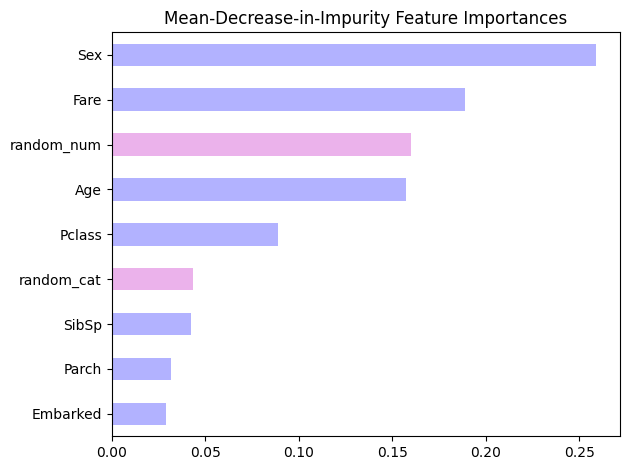

In [4]:
feature_names = rf[:-1].get_feature_names_out()
feature_importances = rf[-1].feature_importances_
mdi_importances = pd.Series(feature_importances,index=feature_names).sort_values(ascending=True)
colors = ['b']*len(mdi_importances)
colors[(mdi_importances.index).tolist().index('random_num')] = 'm'
colors[(mdi_importances.index).tolist().index('random_cat')] = 'm'
ax = mdi_importances.plot.barh(color=colors,alpha=0.3)
ax.set_title("Mean-Decrease-in-Impurity Feature Importances")
ax.figure.tight_layout()

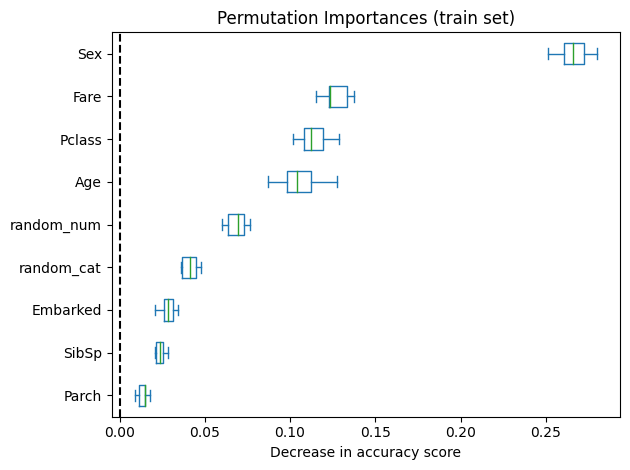

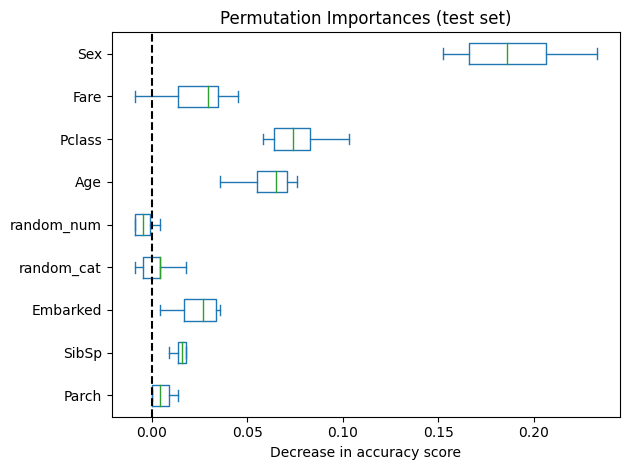

In [5]:
train_result = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=42)
test_results = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
sorted_importances_idx = train_result.importances_mean.argsort()
train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()